# Hybride (lightFM)

Exploration du module lightFM, modèle hybride combinant content_based et collaborative filtering

## Imports

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

# all lightfm imports 
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

# imports re for text cleaning 
import re
from datetime import datetime, timedelta

# we will ignore pandas warning 
import warnings
warnings.filterwarnings('ignore')

#others
import itertools

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

C:\Users\Alumet\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Data import

In [2]:
#### import tous les donées##########
base_path = 'filtered data/'

df_train = pd.read_csv(base_path + 'filtered_rating_fm_dataset_train.csv', index_col=0)

df_test = pd.read_csv(base_path + 'filtered_rating_fm_dataset_test.csv', index_col=0)

df_user_features = pd.read_csv(base_path+'user_features_fm_dataset.csv', index_col=0)

df_track_features = pd.read_csv(base_path + 'track_features_fm_dataset_normalized.csv', index_col=0)

## Fonctions

In [3]:
##################################################
# tous les functions utiles
#################################################
def create_features(dataframe, features_name, id_col_name):
    """
    Generate features that will be ready for feeding into lightfm

    Parameters
    ----------
    dataframe: Dataframe
        Pandas Dataframe which contains features
    features_name : List
        List of feature columns name avaiable in dataframe
    id_col_name: String
        Column name which contains id of the question or
        answer that the features will map to.
        There are two possible values for this variable.
        1. questions_id_num
        2. professionals_id_num

    Returns
    -------
    Pandas Series
        A pandas series containing process features
        that are ready for feed into lightfm.
        The format of each value
        will be (user_id, ['feature_1', 'feature_2', 'feature_3'])
        Ex. -> (1, ['military', 'army', '5'])
    """

    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = list(zip(dataframe[id_col_name], features))
    return features



def generate_feature_list(dataframe, features_name):
    """
    Generate features list for mapping 

    Parameters
    ----------
    dataframe: Dataframe
        Pandas Dataframe for Users or Q&A. 
    features_name : List
        List of feature columns name avaiable in dataframe. 
        
    Returns
    -------
    List of all features for mapping 
    """
    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = features.apply(pd.Series).stack().reset_index(drop=True)
    return features


def calculate_auc_score(lightfm_model, interactions_matrix, 
                        track_features, user_features): 
    """
    Measure the ROC AUC metric for a model. 
    A perfect score is 1.0.

    Parameters
    ----------
    lightfm_model: LightFM model 
        A fitted lightfm model 
    interactions_matrix : 
        A lightfm interactions matrix 
    question_features, professional_features: 
        Lightfm features 
        
    Returns
    -------
    String containing AUC score 
    """
    score = auc_score( 
        lightfm_model, interactions_matrix, 
        item_features=track_features, 
        user_features=user_features,
        num_threads=3).mean()
    return score

In [4]:
class k_best():
    def __init__(self, user_tracks, recomended_tracks):
        self.user_tracks = user_tracks
        self.recomended_tracks = recomended_tracks
    
    def CG(self):
        
        return len(set(self.recomended_tracks).intersection(set(self.user_tracks)))
    
    def DCG(self):
        
        result = 0
        for i,id in enumerate(self.recomended_tracks):
            
            if id in self.user_tracks:
                result+=1/np.log2(i+2)

        return result
    
    def IDCG(self):
        
        a = self.CG()
        result=0
        
        for i in range (a):
            result+=1/np.log2(i+2)
        
        return result
    
    def NDCG(self):
        if self.IDCG()!=0:
            result = self.DCG()/self.IDCG()
        else:
            result=0
            
        return result
    
    def P_at_k(self):
        
        return self.CG()/len(self.recomended_tracks)

    
    def __str__(self):
        
        result = 'K_best ressults: \n'
        result+= f'CG = {self.CG()}\n'
        result+= f'DCG = {self.DCG()}\n'
        result+= f'NDCG = {self.NDCG()}\n'
        result+= f'P@K = {self.P_at_k()}\n'
        
        return result

## Data preparation

In [5]:
df_train['weights'] = df_train['rating']+1
df_test['weights'] = df_test['rating']+1

### Filtre des Track_id

In [6]:
track_id_to_keep_tack = set(df_track_features['track_id'].unique())
track_id_to_keep_train = set(df_train['track_id'].unique())

track_id_to_keep = track_id_to_keep_tack.intersection(track_id_to_keep_train)

In [7]:
filter = df_train['track_id'].apply(lambda x: x in track_id_to_keep)
df_train = df_train[filter]

In [8]:
filter = df_test['track_id'].apply(lambda x: x in track_id_to_keep)
df_test = df_test[filter]

In [9]:
filter = df_track_features['track_id'].apply(lambda x: x in track_id_to_keep)
df_track_features = df_track_features[filter]

### Filtre des user_id

In [10]:
user_id_to_keep_user = set(df_user_features['user_id'].unique())
user_id_to_keep_train = set(df_train['user_id'].unique())

user_id_to_keep = user_id_to_keep_user.intersection(user_id_to_keep_train)

In [11]:
filter = df_train['user_id'].apply(lambda x: x in user_id_to_keep)
df_train = df_train[filter]

In [12]:
filter = df_test['user_id'].apply(lambda x: x in user_id_to_keep)
df_test = df_test[filter]

In [13]:
filter = df_user_features['user_id'].apply(lambda x: x in user_id_to_keep)
df_user_features = df_user_features[filter]

### Verification

In [14]:
print('train nb track: ', df_train['track_id'].nunique())
print('test nb track: ', df_test['track_id'].nunique())
print('track_features nb track: ', df_track_features['track_id'].nunique())

train nb track:  42304
test nb track:  42304
track_features nb track:  42304


In [15]:
print('train nb user: ', df_train['user_id'].nunique())
print('test nb user: ', df_test['user_id'].nunique())
print('user_features nb user: ', df_user_features['user_id'].nunique())

train nb user:  959
test nb user:  959
user_features nb user:  959


### Creation des tags (user et item)

### User

In [16]:
df_user_features['user_tags'] = df_user_features[df_user_features.columns[1:5]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)

In [17]:
user_features_list = generate_feature_list(df_user_features,['user_tags'])

In [18]:
df_user_features['user_features'] = create_features(df_user_features, ['user_tags'], 'user_id')

### Item

In [19]:
df_track_features['item_tags'] = df_track_features[df_track_features.columns[3:25]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)

In [20]:
item_features_list = generate_feature_list(df_track_features,['item_tags'])

In [21]:
df_track_features['item_features'] = create_features(df_track_features, ['item_tags'], 'track_id')

## Dataset build

In [22]:
user_features_id = df_user_features['user_id'].unique()
track_features_id =  df_track_features['track_id'].unique()

In [23]:
########################
# Train Dataset building for lightfm
########################


dataset = Dataset()
dataset.fit(
    user_features_id, 
    track_features_id,
    item_features = item_features_list, 
    user_features = user_features_list)

In [24]:
track_features = dataset.build_item_features(df_track_features['item_features'])
user_features = dataset.build_user_features(df_user_features['user_features'])

### Train

In [25]:
df_train['user_track_id_tuple'] = list(zip(df_train.user_id, df_train.track_id, df_train.weights))

interactions_train, weights_train = dataset.build_interactions(df_train['user_track_id_tuple'])

### Test

In [26]:
df_test['user_track_id_tuple'] = list(zip(df_test.user_id, df_test.track_id, df_test.weights))

interactions_test, weights_test = dataset.build_interactions(df_test['user_track_id_tuple'])

### Modèle

In [27]:
################################
# Model building part
################################

# define lightfm model by specifying hyper-parametre
# then fit the model with ineteractions matrix, item and user features 
model = LightFM(
    no_components=80,
    learning_rate=0.95,
    learning_schedule='adagrad',
    loss='warp',
    max_sampled=7,
    random_state=42)

model.fit(
    interactions_train,
    item_features = track_features,
    user_features = user_features, sample_weight = weights_train,
    epochs=5, num_threads=3, verbose=True)

Epoch: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [11:37<00:00, 139.54s/it]


In [28]:
train_score = calculate_auc_score(model, interactions_train, track_features, user_features)
test_score = calculate_auc_score(model, interactions_test, track_features, user_features)

print('Train AUC: ', train_score)
print('Test AUC: ', test_score)

Train AUC:  0.97176856
Test AUC:  0.83378214


In [29]:
train_precision = precision_at_k(model, interactions_train, k=50, item_features=track_features, user_features=user_features).mean()
test_precision = precision_at_k(model, interactions_test, k=50, item_features=track_features, user_features=user_features).mean()

print('train P@50: ', train_precision )
print('Test P@50: ', test_precision)

train P@50:  0.66777897
Test P@50:  0.058706984


## Evaluation

In [30]:
labels = np.array(df_track_features['artist_name']+'--'+df_track_features['track_name'])
id = np.array(df_track_features['track_id'])

In [31]:
def sample_recommendation_id(model, data, user_id, n=50):

    n_users, n_items = data.shape

    #build a structure to store user scores for each item
    all_scores = np.empty(shape=(0,n_items))

    scores = model.predict(user_id,np.arange(n_items),track_features,user_features)

    top_items_for_user = id[np.argsort(-scores)]
    if n>=0:
        return top_items_for_user[:n]
    else:
        return zip(top_items_for_user, scores[np.argsort(-scores)])

In [43]:
def sample_recommendation_score(model, data, user_id):

    n_users, n_items = data.shape

    #build a structure to store user scores for each item
    all_scores = np.empty(shape=(0,n_items))

    scores = model.predict(user_id,np.arange(n_items),track_features,user_features)

    return pd.DataFrame({'track_id':id,'score':scores})

### Test sur 1 utilisateur 

In [33]:
user = 1

inner_user = int(np.where(user_features_id==user)[0][0])

user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])

recommendation = sample_recommendation_id(model,interactions_train,inner_user)

In [34]:
k = k_best(user_tracks_train, recommendation)
print(k)

K_best ressults: 
CG = 42
DCG = 11.066931216459178
NDCG = 0.9656358768255692
P@K = 0.84



In [35]:
k = k_best(user_tracks_test, recommendation)
print(k)

K_best ressults: 
CG = 1
DCG = 0.18208790046993825
NDCG = 0.18208790046993825
P@K = 0.02



## Evaluation sur tous les utilisateurs

### K_best

In [36]:
train_scores = list()
test_scores = list()
user_id = list()

for user in tqdm(df_train['user_id'].unique()):
    user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
    user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])
    
    inner_user = int(np.where(user_features_id==user)[0][0])
    recomended_tracks = sample_recommendation_id(model,interactions_train,inner_user)
    
    k = k_best(user_tracks_train, recomended_tracks)
    train_scores.append(k.NDCG())
    
    if len(user_tracks_test)!=0:
        k = k_best(user_tracks_test, recomended_tracks)
        test_scores.append(k.NDCG())
        
    else:
        test_scores.append(0)
    
    user_id.append(user)

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [00:57<00:00, 16.64it/s]


In [37]:
print('Train_mean_NDCG = ', np.array(train_scores).mean())
print('Test_mean_NDCG = ', np.array(test_scores).mean())

Train_mean_NDCG =  0.8508080998897113
Test_mean_NDCG =  0.30795657167865575


### AUC_ROC

In [38]:
scores = dict()

for s in np.linspace(100,200,20):
    scores[s]={'train':[], 'test':[]}


for user in tqdm(df_train['user_id'].unique()):
    
    user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
    user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])
    
    inner_user = int(np.where(user_features_id==user)[0][0])
    recomended_tracks = sample_recommendation_score(model,interactions_train,inner_user)
    
    recomended_tracks['true_train'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_train else 0)
    recomended_tracks['true_test'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_test else 0)
    
    for s in np.linspace(100,200,20):
    
        recomended_tracks['pred'] = recomended_tracks['score'].apply(lambda x : 1 if x<s else 0)
        y_pred = recomended_tracks['pred'].values

        y_true_train = recomended_tracks['true_train'].values
        score = roc_auc_score(y_true_train, y_pred)  
        scores[s]['train'].append(score)

        y_true_test = recomended_tracks['true_test'].values
        score = roc_auc_score(y_true_test, y_pred)
        scores[s]['test'].append(score)

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [09:35<00:00,  1.67it/s]


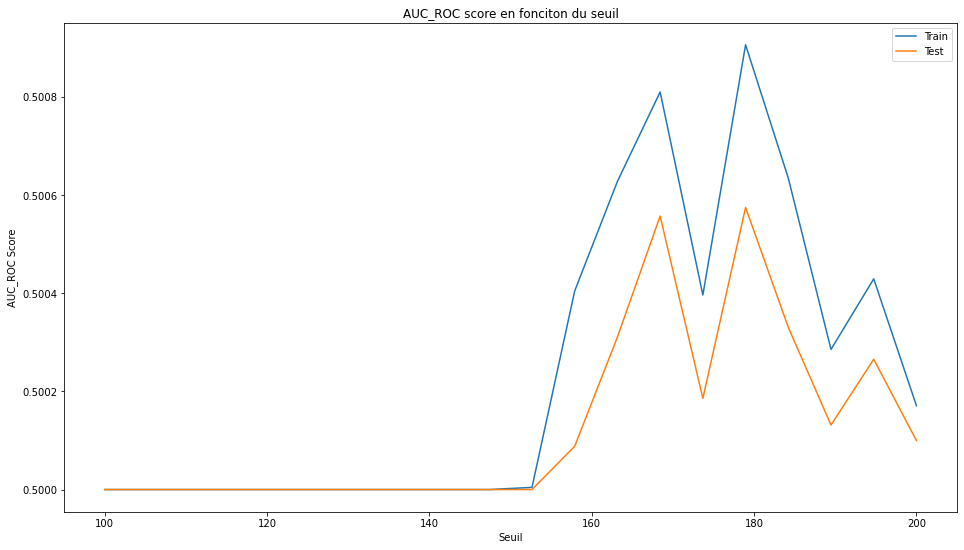

In [39]:
train_score = list()
test_score = list()
seuil = list()

for key in scores.keys():
    train_score.append(np.array(scores[key]['train']).mean())
    test_score.append(np.array(scores[key]['test']).mean())
    seuil.append(key)


plt.figure(figsize=(16,9))
plt.plot(seuil, train_score, label='Train')
plt.plot(seuil, test_score, label='Test')
plt.legend()

plt.title('AUC_ROC score en fonciton du seuil')
plt.xlabel('Seuil')
plt.ylabel('AUC_ROC Score')
plt.show

plt.savefig("AUC_ROC score en fonction du seuil, lightFM", dpi=300, pad_inches=0.1,bbox_inches='tight')

In [40]:
x = np.array([3, 1, 2])
np.argsort(x)

array([1, 2, 0], dtype=int64)

In [42]:
x[np.argsort(-x)]

array([3, 2, 1])

In [58]:
sample_recommendation_score(model,interactions_train,89).describe()

,track_id,score
count,42304.000000,42304.000000
mean,38705.501678,-1508.991333
std,23338.682730,1.903972
min,0.000000,-1516.329590
25%,18283.750000,-1510.327393
50%,37755.500000,-1509.067322
75%,58759.250000,-1507.735474
max,80598.000000,-1501.702393


In [54]:
np.linspace(-1000,-1200,20)

array([-1000.        , -1010.52631579, -1021.05263158, -1031.57894737,
       -1042.10526316, -1052.63157895, -1063.15789474, -1073.68421053,
       -1084.21052632, -1094.73684211, -1105.26315789, -1115.78947368,
       -1126.31578947, -1136.84210526, -1147.36842105, -1157.89473684,
       -1168.42105263, -1178.94736842, -1189.47368421, -1200.        ])